In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob, os, yaml, sparse, itertools, subprocess, sys, pickle, re, collections, shutil
from functools import reduce

import Bio.SeqUtils
import Bio.Data
from Bio import SeqIO
from Bio.Seq import Seq

plt.rcParams['figure.dpi'] = 150
plt.rcParams['axes.titlepad'] = 10
import scipy.stats as st
import warnings
warnings.filterwarnings("ignore")

from matplotlib.ticker import FormatStrFormatter
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.preprocessing import StandardScaler
import statsmodels.stats.api as sm

results_dir = "/n/data1/hms/dbmi/farhat/Sanjana/CNN_results"
data_dir = "/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/single_drugs"

h37Rv = SeqIO.read("/n/data1/hms/dbmi/farhat/Sanjana/H37Rv/GCF_000195955.2_ASM19595v2_genomic.gbff", "genbank")
h37Rv_genes = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/H37Rv/mycobrowser_h37rv_genes_v4.csv")

who_variants_regression = pd.read_csv("~/who-analysis/results/Nov2024_Tier1.csv")

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETO",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMK",
                  "Pretomanid": "PMD",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LFX",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

abbr_drug_dict = {val: key for key, val in drug_abbr_dict.items()}

# isolate_variants = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/TRUST/WHO_catalog_isolate_variants.csv")

silent_lst = ['synonymous_variant', 'initiator_codon_variant', 'stop_retained_variant']
isolate_variants = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/MIC_data/TRUST/isolate_variants_WHO_catalog.csv")

cc_df = pd.read_csv("/home/sak0914/who-analysis/data/drug_CC.csv")

# MIC encoding from the TRUST codebook
MIC_encoding_dicts = {'RIF': {1: '0,0.03', 2: '0.03,0.06', 3: '0.06,0.125', 4: '0.125,0.25', 5: '0.25,0.5', 6: '0.5,1', 7: '1,inf'},
                      'INH': {1: '0,0.025', 2: '0.025,0.05', 3: '0.05,0.1', 4: '0.1,0.2', 5: '0.2,inf'},
                      'EMB': {1: '0,0.6', 2: '0.6,1.25', 3: '1.25,2.5', 4: '2.5,5', 5: '5,inf'},
                      'PZA': {1: '0,25', 2: '25,50', 3: '50,75', 4: '75,100', 5: '100,inf'}
                     }

RIF_label_encoding_dict = {1: '≤0.03', 2: '0.03-0.06', 3: '0.06-0.125', 4: '0.125-0.25', 5: '0.25-0.5', 6: '0.5-1', 7: '>1'}
INH_label_encoding_dict = {1: '≤0.025', 2: '0.025-0.05', 3: '0.05-0.1', 4: '0.1-0.2', 5: '>0.2'}
EMB_label_encoding_dict = {1: '≤0.6', 2: '0.6-1.25', 3: '1.25-2.5', 4: '2.5-5', 5: '>5'}
PZA_label_encoding_dict = {1: '≤25', 2: '25-50', 3: '50-75', 4: '75-100', 5: '>100'}

MIC_label_encoding_dicts = {'RIF': RIF_label_encoding_dict, 'INH': INH_label_encoding_dict, 'EMB': EMB_label_encoding_dict, 'PZA': PZA_label_encoding_dict}

df_WGS = pd.read_csv("/n/data1/hms/dbmi/farhat/rollingDB/TRUST/Illumina_culture_WGS_summary.csv")

In [16]:
df = pd.read_csv("/n/data1/hms/dbmi/farhat/rollingDB/metadata/isolate_metadata.csv")

In [11]:
df.loc[df['ROLLINGDB_ID'].str.contains('|'.join(['ERR', 'SRR', 'DRR']))].DB_OF_ORIGIN.unique()

array(['walker', 'guerra', 'bryant', 'trauner', 'witney', 'casali',
       'reseqtb', 'xu', 'NN_validation'], dtype=object)

In [20]:
df.loc[~pd.isnull(df['OtherNames'])]

,ROLLINGDB_ID,BIOSAMPLE_ACCESSION,SAMPLE,RUN,DB_OF_ORIGIN,ISOLATION_DATE,ISOLATION_COUNTRY,ISOLATION_REGION,SPUTUM/CULTURE,UNPAIRED/PAIRED,Platform,Model,SPECIES,TaxID,ReleaseDate,LoadDate,Combined_Runs,Num_Runs,OtherNames
12,SAMEA3402472,SAMEA3402472,ERS2401192,ERR2516514,farhat_internal,NaN,Peru,Peru,1.0,1.0,ILLUMINA,Illumina HiSeq 2500,Mycobacterium tuberculosis,1773.0,2018-09-25 09:28:46,2021-10-23 19:14:21,ERR2516514,1.0,02-R0759
17,SAMEA3401962,SAMEA3401962,ERS2401175,ERR2516497,farhat_internal,NaN,Peru,Peru,1.0,1.0,ILLUMINA,Illumina HiSeq 2500,Mycobacterium tuberculosis,1773.0,2018-09-25 09:28:46,2021-10-23 19:13:14,ERR2516497,1.0,02-R0984
22,SAMEA3402854,SAMEA3402854,ERS2401201,ERR2516523,farhat_internal,NaN,Peru,Peru,1.0,1.0,ILLUMINA,Illumina HiSeq 2500,Mycobacterium tuberculosis,1773.0,2018-09-25 09:28:46,2021-10-23 19:14:22,ERR2516523,1.0,02-R1630
25,SAMN22416402,SAMN22416402,SRS10661667,SRR16509481,cetr,NaN,Peru,Peru,1.0,1.0,ILLUMINA,Illumina HiSeq 2500,Mycobacterium tuberculosis,1773.0,2021-10-21 04:55:39,2021-10-21 04:47:01,SRR16509481,1.0,03-R0154
77,SAMN20693073,SAMN20693073,SRS10600938,SRR16370504,NaN,NaN,NaN,NaN,1.0,1.0,ILLUMINA,NextSeq 500,Mycobacterium tuberculosis,1773.0,2021-10-16 19:12:15,2021-10-16 19:10:40,SRR16370504,1.0,1479144119992T178015lib4985nextseqn0035151bp
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60430,SAMN37457538,SAMN37457538,SRS18925735,SRR26112101,Wadsworth,2021,USA,NY,1.0,1.0,ILLUMINA,Illumina MiSeq,Mycobacterium tuberculosis,1773.0,2023-09-19 17:14:09,2023-09-19 16:19:50,SRR26112101,1.0,IDR2100083967
60431,SAMN37480150,SAMN37480150,SRS18937012,SRR26124830,Wadsworth,2022,USA,NY,1.0,1.0,ILLUMINA,NextSeq 500,Mycobacterium tuberculosis,1773.0,2023-09-20 22:39:59,2023-09-20 20:31:45,SRR26124830,1.0,IDR2200025003
60432,SAMN37458082,SAMN37458082,SRS18926083,SRR26112440,Wadsworth,2022,USA,NY,1.0,1.0,ILLUMINA,NextSeq 500,Mycobacterium tuberculosis,1773.0,2023-09-19 17:14:13,2023-09-19 16:20:34,SRR26112440,1.0,IDR2200050648
60433,SAMN37480153,SAMN37480153,SRS18937004,SRR26124839,Wadsworth,2022,USA,NY,1.0,1.0,ILLUMINA,Illumina MiSeq,Mycobacterium tuberculosis,1773.0,2023-09-20 22:39:59,2023-09-20 20:32:27,SRR26124839,1.0,IDR2200058676


In [4]:
df.head(50)

,ROLLINGDB_ID,BIOSAMPLE_ACCESSION,SAMPLE,RUN,DB_OF_ORIGIN,ISOLATION_DATE,ISOLATION_COUNTRY,ISOLATION_REGION,SPUTUM/CULTURE,UNPAIRED/PAIRED,Platform,Model,SPECIES,TaxID,ReleaseDate,LoadDate,Combined_Runs,Num_Runs,OtherNames
0,00-R1210,NaN,NaN,NaN,farhat_internal,NaN,Peru,Peru,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN
1,01-R0573_ACTTGA_L003,NaN,NaN,NaN,Murray,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN
2,01-R0913_TAGCTT_L003,NaN,NaN,NaN,Murray,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN
3,01-R0955_GGCTAC_L003,NaN,NaN,NaN,Murray,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN
4,01-R1165_CGATGT_L001,NaN,NaN,NaN,Murray,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN
5,01-R1169_TGACCA_L001,NaN,NaN,NaN,Murray,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN
6,01-R1390_ACAGTG_L001,NaN,NaN,NaN,Murray,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN
7,01-r1038,NaN,NaN,NaN,farhat_internal,NaN,Peru,Peru,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN
8,02-R0106_GCCAAT_L001,NaN,NaN,NaN,Murray,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN
9,02-R0198_CAGATC_L001,NaN,NaN,NaN,Murray,NaN,NaN,NaN,1.0,1.0,NaN,NaN,Mycobacterium tuberculosis,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
bcftools norm --rm-dup none --fasta /home/sak0914/Mtb_Megapipe/references/ref_genome/H37Rv_NC_000962.3.fna MFS-409.seedLength80.vcf.gz  | bcftools sort | bcftools view --types snps,indels,mnps,other > MFS-409.seedLength80.variants.vcf




In [ ]:
freebayes -f /home/sak0914/Mtb_Megapipe/references/ref_genome/H37Rv_NC_000962.3.fna -p 1 --min-mapping-quality 30 --min-base-quality 30 --min-alternate-fraction 0.01 -b MFS-409.seedLength80.dedup.bam -v MFS-409.seedLength80.vcf



bcftools norm --rm-dup none --fasta-ref /home/sak0914/Mtb_Megapipe/references/ref_genome/H37Rv_NC_000962.3.fna MFS-409.seedLength80.freebayes.vcf | bcftools sort | gzip -c > MFS-409.seedLength80.vcf.gz

# save the variants only (non-REF calls) to another VCF file. Split multi-allelic sites for easier parsing of the variants
# however, because of the shifting positions due to left-aligning indels above, the position of the indel can change, so need to sort it again
bcftools view --types snps,indels,mnps,other MFS-409.seedLength80.vcf.gz | bcftools norm --multiallelics -any '-' | bcftools sort > MFS-409.seedLength80.freebayes.variants.vcf

# Create an isolate_variants files of the DR regions

```bash
# Subset the Freebayes VCFs using the WHO regions BED file
variants_dir="/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/samples"

for fName in /n/data1/hms/dbmi/farhat/rollingDB/TRUST/Illumina_culture_WGS_processed/*/freebayes/*_variants.eff.vcf; do
    
    baseName=$(basename "$fName" | cut -d'_' -f1)
    
    out_vcf_fName="$variants_dir/$baseName/$baseName.variants.excludeLowConf.WHOcatalogDRregions.vcf"

    # phase variation regions of interest
    bedtools intersect -a "$variants_dir/$baseName/$baseName.variants.excludeLowConf.vcf" -b /home/sak0914/Mtb_Megapipe/references/WHO_catalog_resistance/regions.bed -header > $out_vcf_fName
    
    # use snpsift to extract the variants to a TSV file
    # get all field names because not sure which ones we will need for low AF variant detection
    echo -e "POS\nREF\nALT\nQUAL\nFILTER\nANN[*].GENE\nANN[*].HGVS_C\nANN[*].HGVS_P\nANN[*].EFFECT" > /home/sak0914/field_names.txt
    grep "^##INFO=<ID=" $out_vcf_fName | cut -d'=' -f3 | cut -d',' -f1 >> /home/sak0914/field_names.txt
    grep "^##FORMAT=<ID=" $out_vcf_fName | cut -d'=' -f3 | cut -d',' -f1 >> /home/sak0914/field_names.txt

    # extract all variants to a TSV file. Keep all fields 
    SnpSift extractFields $out_vcf_fName $(paste -sd " " /home/sak0914/field_names.txt) -e "" > "$variants_dir/$baseName/$baseName.variants.excludeLowConf.WHOcatalogDRregions.tsv"

    echo "Finished $baseName"
done

# process the TSV files using the helper script in Mtb_Megapipe to create an _annot.tsv file
for file in /n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/samples/*/*.variants.excludeLowConf.WHOcatalogDRregions.tsv; do
    python3 /home/sak0914/Mtb_Megapipe/scripts/process_variants_for_WHO_catalog.py -i $file
    echo "Finished $file"
done
````

# Process the names for easy analysis and combine the TSV files together

In [2]:
finished_files = glob.glob(f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/samples/*/*.variants.excludeLowConf.WHOcatalogDRregions.annot.tsv")
len(finished_files)

753

In [41]:
df_DR_variants = []

for fName in glob.glob(f"/n/data1/hms/dbmi/farhat/Sanjana/TRUST_longitudinal_genetic_diversity/samples/*/*.variants.excludeLowConf.WHOcatalogDRregions.annot.tsv"):
    
    df = pd.read_csv(fName, sep='\t', on_bad_lines='skip')
    
    # AF = AO / DP
    df['AF'] = df['AO'] / df['DP']
    df['SampleID'] = os.path.basename(fName).split('.')[0]
    
    df_DR_variants.append(df)

df_DR_variants = pd.concat(df_DR_variants)
print(df_DR_variants.SampleID.nunique())

df_DR_variants = df_DR_variants.merge(df_WGS[['SampleID', 'Kraken_Unclassified_Percent', 'F2', 'Coll2014', 'Freschi2020']], on='SampleID', how='left')

# add regression catalog gradings
df_DR_variants = df_DR_variants.merge(who_variants_regression[['Drug', 'mutation', 'REGRESSION + GRADING RULES']].rename(columns={'Drug': 'drug', 'mutation': 'variant', 'REGRESSION + GRADING RULES': 'regression_confidence'}), on=['drug', 'variant'], how='left')

# these are upper bounds on the probability of observing the observed deviation between SRF and SRR or between SAF and SAR, given that the expected probability 
df_DR_variants['SRP_prob'] = 10**(-df_DR_variants['SRP']/10)
df_DR_variants['SAP_prob'] = 10**(-df_DR_variants['SAP']/10)

# when SRF = SRR = 0, there are no reads supporting the reference. If quality is 0, then the error probability is 1, which isn't true. They're actually NA
df_DR_variants.loc[(df_DR_variants['SRF']==0) | (df_DR_variants['SRR']==0), 'SRP_prob'] = np.nan

753


In [42]:
num_support_each_direction = 2
AF_max = 0.9

# exclude rrs and rrl, and maybe rpoB?
exclude_genes = ['rrs', 'rrl']#, 'rpoB']

# 1416222, 1416232, and 1416234 are suspicious sites in embR
exclude_pos = [1416222, 1416232, 1416234]

df_DR_lowAF_variants = df_DR_variants.query("EFFECT not in @silent_lst & Kraken_Unclassified_Percent <= 10 & F2 <= 0.03 & AF >= 0.05 & AF <= @AF_max & SAF >= @num_support_each_direction & SAR >= @num_support_each_direction & SAP_prob > 0.05 & GENE not in @exclude_genes & POS not in @exclude_pos")

In [43]:
df_DR_lowAF_variants.query("regression_confidence in ['1) Assoc w R', '2) Assoc w R - Interim']")

,POS,REF,ALT,QUAL,FILTER,ANN[*].GENE,ANN[*].HGVS_C,ANN[*].HGVS_P,ANN[*].EFFECT,NS,...,drug,confidence,SampleID,Kraken_Unclassified_Percent,F2,Coll2014,Freschi2020,regression_confidence,SRP_prob,SAP_prob


In [44]:
df_DR_lowAF_variants.query("confidence != regression_confidence").dropna(subset=['confidence', 'regression_confidence'])

,POS,REF,ALT,QUAL,FILTER,ANN[*].GENE,ANN[*].HGVS_C,ANN[*].HGVS_P,ANN[*].EFFECT,NS,...,drug,confidence,SampleID,Kraken_Unclassified_Percent,F2,Coll2014,Freschi2020,regression_confidence,SRP_prob,SAP_prob


In [46]:
df_DR_lowAF_variants.regression_confidence.unique()

array([nan, '3) Uncertain significance'], dtype=object)

In [53]:
df_DR_variants.query("variant=='whiB6_c.-75delG'")

,POS,REF,ALT,QUAL,FILTER,ANN[*].GENE,ANN[*].HGVS_C,ANN[*].HGVS_P,ANN[*].EFFECT,NS,...,drug,confidence,SampleID,Kraken_Unclassified_Percent,F2,Coll2014,Freschi2020,regression_confidence,SRP_prob,SAP_prob
66,4338595,GC,G,8725.41,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,Amikacin,5) Not assoc w R,MFS-1,0.37,0.011212,2.2.1.1,2.2.1.1.1,NaN,NaN,0.231902
67,4338595,GC,G,8725.41,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,Capreomycin,5) Not assoc w R,MFS-1,0.37,0.011212,2.2.1.1,2.2.1.1.1,NaN,NaN,0.231902
68,4338595,GC,G,8725.41,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,Kanamycin,5) Not assoc w R,MFS-1,0.37,0.011212,2.2.1.1,2.2.1.1.1,NaN,NaN,0.231902
118,4338595,GC,G,9515.84,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,Amikacin,5) Not assoc w R,MFS-10,0.37,0.009122,4.3.2.1,4.2.1.2.1.1.i1,NaN,NaN,0.030135
119,4338595,GC,G,9515.84,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,Capreomycin,5) Not assoc w R,MFS-10,0.37,0.009122,4.3.2.1,4.2.1.2.1.1.i1,NaN,NaN,0.030135
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76330,4338595,GC,G,9465.43,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,Capreomycin,5) Not assoc w R,MFS-98,0.52,0.018668,4.1.1.3,4.1.i1.2.1,NaN,NaN,0.009099
76331,4338595,GC,G,9465.43,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,Kanamycin,5) Not assoc w R,MFS-98,0.52,0.018668,4.1.1.3,4.1.i1.2.1,NaN,NaN,0.009099
76368,4338595,GC,G,6839.50,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,Amikacin,5) Not assoc w R,MFS-99,0.53,0.018140,4.1.1.3,4.1.i1.2.1,NaN,NaN,0.028428
76369,4338595,GC,G,6839.50,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,Capreomycin,5) Not assoc w R,MFS-99,0.53,0.018140,4.1.1.3,4.1.i1.2.1,NaN,NaN,0.028428


In [48]:
df_DR_lowAF_variants.query("confidence=='5) Not assoc w R'")[['variant']]

,variant
56489,whiB6_c.-75delG
56490,whiB6_c.-75delG
56491,whiB6_c.-75delG
58159,glpK_p.Val192fs


In [36]:
who_variants_regression

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
0,Amikacin,rrs,rrs_n.1401A>G,non_coding_transcript_exon_variant,4.572307,0.000,0.000000,1.000,1.000000,0.000000e+00,...,0.732114,0.990498,0.992973,Assoc w R,1) Assoc w R,Both Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R
1,Amikacin,eis,eis_c.-14C>T,upstream_gene_variant,1.388788,0.000,0.000000,1.000,1.000000,8.131331e-39,...,0.045699,0.988936,0.991616,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,2) Assoc w R - Interim,3) Uncertain significance,2) Assoc w R - Interim
2,Amikacin,rrs,rrs_n.1484G>T,non_coding_transcript_exon_variant,1.184533,0.000,0.000000,1.000,1.000000,3.730510e-25,...,0.010560,0.999013,0.999708,Assoc w R,1) Assoc w R,Both Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R
3,Amikacin,eis,eis_p.Trp36Arg,missense_variant,1.036746,0.077,0.332973,0.409,0.586906,2.171860e-01,...,0.006159,0.999587,0.999971,Assoc w R,2) Assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,2) Assoc w R - Interim,2) Assoc w R - Interim
4,Amikacin,rrs,rrs_n.1402C>T,non_coding_transcript_exon_variant,1.122668,0.000,0.000000,0.979,1.000000,4.007362e-09,...,0.007295,0.998835,0.999605,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,2) Assoc w R - Interim,3) Uncertain significance,2) Assoc w R - Interim
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21584,Streptomycin,whiB7,whiB7_c.-159G>A,upstream_gene_variant,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3) Uncertain significance,Not Graded,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
21585,Streptomycin,whiB7,whiB7_c.-1C>A,upstream_gene_variant,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3) Uncertain significance,Not Graded,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
21586,Streptomycin,whiB7,whiB7_c.-52_-51insC,upstream_gene_variant,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3) Uncertain significance,Not Graded,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
21587,Streptomycin,whiB7,whiB7_p.Leu18Phe,missense_variant,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,3) Uncertain significance,Not Graded,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance


In [6]:
df_DR_variants.query("variant=='whiB6_c.-73_-75delAGCinsTG'")

,POS,REF,ALT,QUAL,FILTER,ANN[*].GENE,ANN[*].HGVS_C,ANN[*].HGVS_P,ANN[*].EFFECT,NS,...,variant,drug,confidence,SampleID,Kraken_Unclassified_Percent,F2,Coll2014,Freschi2020,SRP_prob,SAP_prob
16368,4338594,AGC,TG,3052.40,NaN,whiB6-Rv3863,n.4338594_4338596delAGCinsTG,NaN,intergenic_region,1.0,...,whiB6_c.-73_-75delAGCinsTG,NaN,NaN,MFS-306,0.51,0.012589,2.2.1.1,2.2.1.1.1,0.262894,0.229091
18071,4338594,AGC,TG,6594.21,NaN,whiB6-Rv3863,n.4338594_4338596delAGCinsTG,NaN,intergenic_region,1.0,...,whiB6_c.-73_-75delAGCinsTG,NaN,NaN,MFS-325,0.53,0.011467,2.2.1.1,2.2.1.1.1,0.349836,0.440815
18158,4338594,AGC,TG,5931.54,NaN,whiB6-Rv3863,n.4338594_4338596delAGCinsTG,NaN,intergenic_region,1.0,...,whiB6_c.-73_-75delAGCinsTG,NaN,NaN,MFS-326,0.43,0.013818,2.2.1.1,2.2.1.1.1,0.059325,0.317635


In [14]:
df_DR_variants

,POS,REF,ALT,QUAL,FILTER,ANN[*].GENE,ANN[*].HGVS_C,ANN[*].HGVS_P,ANN[*].EFFECT,NS,...,variant,drug,confidence,SampleID,Kraken_Unclassified_Percent,F2,Coll2014,Freschi2020,SRP_prob,SAP_prob
0,9,T,C,4.134550e-14,NaN,dnaA,c.9T>C,p.Asp3Asp,synonymous_variant,1.0,...,dnaA_c.9T>C,NaN,NaN,MFS-1,0.37,0.011212,2.2.1.1,2.2.1.1.1,0.303265,0.111565
1,33,A,G,0.000000e+00,NaN,dnaA,c.33A>G,p.Thr11Thr,synonymous_variant,1.0,...,dnaA_c.33A>G,Isoniazid,4) Not assoc w R - Interim,MFS-1,0.37,0.011212,2.2.1.1,2.2.1.1.1,0.499153,0.111565
2,7362,G,C,1.021890e+04,NaN,gyrA,c.61G>C,p.Glu21Gln,missense_variant,1.0,...,gyrA_p.Glu21Gln,Levofloxacin,5) Not assoc w R,MFS-1,0.37,0.011212,2.2.1.1,2.2.1.1.1,NaN,0.000018
3,7362,G,C,1.021890e+04,NaN,gyrA,c.61G>C,p.Glu21Gln,missense_variant,1.0,...,gyrA_p.Glu21Gln,Moxifloxacin,5) Not assoc w R,MFS-1,0.37,0.011212,2.2.1.1,2.2.1.1.1,NaN,0.000018
4,7585,G,C,1.142720e+04,NaN,gyrA,c.284G>C,p.Ser95Thr,missense_variant,1.0,...,gyrA_p.Ser95Thr,Levofloxacin,5) Not assoc w R,MFS-1,0.37,0.011212,2.2.1.1,2.2.1.1.1,NaN,0.038097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76367,4327691,A,G,8.061420e+03,NaN,ethR,c.143A>G,p.Asp48Gly,missense_variant,1.0,...,ethR_p.Asp48Gly,Ethionamide,3) Uncertain significance,MFS-99,0.53,0.018140,4.1.1.3,4.1.i1.2.1,NaN,0.271941
76368,4338595,GC,G,6.839500e+03,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,whiB6_c.-75delG,Amikacin,5) Not assoc w R,MFS-99,0.53,0.018140,4.1.1.3,4.1.i1.2.1,NaN,0.028428
76369,4338595,GC,G,6.839500e+03,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,whiB6_c.-75delG,Capreomycin,5) Not assoc w R,MFS-99,0.53,0.018140,4.1.1.3,4.1.i1.2.1,NaN,0.028428
76370,4338595,GC,G,6.839500e+03,NaN,whiB6-Rv3863,n.4338596delC,NaN,intergenic_region,1.0,...,whiB6_c.-75delG,Kanamycin,5) Not assoc w R,MFS-99,0.53,0.018140,4.1.1.3,4.1.i1.2.1,NaN,0.028428


In [13]:
df_DR_lowAF_variants.query("GENE=='gyrB'")[['SampleID', 'POS', 'REF', 'ALT', 'variant', 'AF', 'confidence']]

,SampleID,POS,REF,ALT,variant,AF,confidence
39484,MFS-546,6923,T,G,gyrB_p.Phe562Val,0.071225,NaN
39573,MFS-547,6923,T,G,gyrB_p.Phe562Val,0.117479,NaN
47685,MFS-639,6078,G,T,gyrB_p.Gly280Val,0.096692,NaN


In [164]:
pd.DataFrame(df_DR_lowAF_variants.drop_duplicates(['SampleID', 'variant']).variant.value_counts()).head(20)

,count
variant,
ethR_p.Ala161Gly,6
ndhA_c.-72_-73insTTGTGGGCC,3
Rv3236c_p.His205_Val206insTyr,3
Rv3863_c.-255_-253delAGCinsTG,3
whiB6_c.-73_-75delAGCinsTG,3
Rv0393_c.-70_-69insTTGTGGGCC,3
dnaA_p.Leu250Ile,2
clpC1_c.-102A>G,2
mpr17_c.-73T>C,2


In [168]:
df_DR_lowAF_variants.query("variant=='ndhA_c.-72_-73insTTGTGGGCC'")[['SampleID', 'POS']]

,SampleID,POS
57913,MFS-765,472711
67907,MFS-823,472711
69635,MFS-832,472711


In [5]:
df_DR_lowAF_variants.query("variant=='whiB6_c.-73_-75delAGCinsTG'")

,POS,REF,ALT,QUAL,FILTER,ANN[*].GENE,ANN[*].HGVS_C,ANN[*].HGVS_P,ANN[*].EFFECT,NS,...,variant,drug,confidence,SampleID,Kraken_Unclassified_Percent,F2,Coll2014,Freschi2020,SRP_prob,SAP_prob
16368,4338594,AGC,TG,3052.40,NaN,whiB6-Rv3863,n.4338594_4338596delAGCinsTG,NaN,intergenic_region,1.0,...,whiB6_c.-73_-75delAGCinsTG,NaN,NaN,MFS-306,0.51,0.012589,2.2.1.1,2.2.1.1.1,0.262894,0.229091
18071,4338594,AGC,TG,6594.21,NaN,whiB6-Rv3863,n.4338594_4338596delAGCinsTG,NaN,intergenic_region,1.0,...,whiB6_c.-73_-75delAGCinsTG,NaN,NaN,MFS-325,0.53,0.011467,2.2.1.1,2.2.1.1.1,0.349836,0.440815
18158,4338594,AGC,TG,5931.54,NaN,whiB6-Rv3863,n.4338594_4338596delAGCinsTG,NaN,intergenic_region,1.0,...,whiB6_c.-73_-75delAGCinsTG,NaN,NaN,MFS-326,0.43,0.013818,2.2.1.1,2.2.1.1.1,0.059325,0.317635


In [159]:
df_WGS.query("Kraken_Unclassified_Percent >= 5 & Kraken_Unclassified_Percent <= 20")

,SampleID,Kraken_Unclassified_Percent,Mean_Depth,Median_Depth,Perc_Sites_10x,Perc_Sites_20x,F2,Coll2014,Freschi2020,Lipworth2019,Shitikov2017,Stucki2016,Lineage,Freschi_Lineage_1,Freschi_Lineage_2,Culture_Mixed_Infection
43,MFS-138,7.09,292.666505,300.0,98.507775,98.362814,0.010892,2.2.1.1,2.2.1.1.1,beijing,"lin2.2.1,pacific_RD150",NaN,2,2.2.1.1.1,NaN,0
98,MFS-188,17.48,233.911604,239.0,98.437935,98.264072,0.011793,2.2.1,2.2.1.1.1,beijing,"lin2.2.1,asian_african_2",NaN,2,2.2.1.1.1,NaN,0
232,MFS-366,13.22,312.759877,316.0,98.901175,98.767186,0.007009,4.8,4.2.1.1.1.1.1.1.i1,NaN,NaN,4.10/PGG3,4,4.2.1.1.1.1.1.1.i1,NaN,0
274,MFS-409,10.60,263.977886,270.0,98.509157,98.351910,0.015020,2.2.1.1,2.2.1.1.1,"beijing,mungi","lin2.2.1,pacific_RD150",NaN,2,2.2.1.1.1,NaN,0
486,MFS-605,18.03,325.947942,310.0,98.965507,98.838340,0.012019,4.1.1.1,4.1.i1.2.1,"xtype,canetti",NaN,4,4,4.1.i1.2.1,NaN,0
669,MFS-778,12.82,285.274752,292.0,98.679189,98.533004,0.011717,2.2.1.1,2.2.1.1.1,"beijing,mungi","lin2.2.1,pacific_RD150",NaN,2,2.2.1.1.1,NaN,0


In [154]:
df_DR_lowAF_variants.query("variant=='rpoB_p.Ser239Asn'")[['SampleID', 'POS', 'REF', 'ALT', 'AF', 'variant', 'confidence', 'Kraken_Unclassified_Percent']]

,SampleID,POS,REF,ALT,AF,variant,confidence,Kraken_Unclassified_Percent
9578,MFS-188,760522,G,A,0.063830,rpoB_p.Ser239Asn,3) Uncertain significance,17.48
26418,MFS-409,760522,G,A,0.077236,rpoB_p.Ser239Asn,3) Uncertain significance,10.60
43706,MFS-605,760522,G,A,0.139726,rpoB_p.Ser239Asn,3) Uncertain significance,18.03


In [144]:
df_DR_lowAF_variants.query("GENE=='glpK' & EFFECT=='frameshift_variant'")

,POS,REF,ALT,QUAL,FILTER,ANN[*].GENE,ANN[*].HGVS_C,ANN[*].HGVS_P,ANN[*].EFFECT,NS,...,variant,drug,confidence,SampleID,Kraken_Unclassified_Percent,F2,Coll2014,Freschi2020,SRP_prob,SAP_prob
58155,4139183,A,AC,0.0,NaN,glpK,c.572dupG,p.Val192fs,frameshift_variant,1.0,...,glpK_p.Val192fs,Ethambutol,3) Uncertain significance,MFS-767,0.44,0.008649,4.1.1.1,4.1.i1.2.1,0.015541,0.370409
58156,4139183,A,AC,0.0,NaN,glpK,c.572dupG,p.Val192fs,frameshift_variant,1.0,...,glpK_p.Val192fs,Isoniazid,3) Uncertain significance,MFS-767,0.44,0.008649,4.1.1.1,4.1.i1.2.1,0.015541,0.370409
58157,4139183,A,AC,0.0,NaN,glpK,c.572dupG,p.Val192fs,frameshift_variant,1.0,...,glpK_p.Val192fs,Levofloxacin,3) Uncertain significance,MFS-767,0.44,0.008649,4.1.1.1,4.1.i1.2.1,0.015541,0.370409
58158,4139183,A,AC,0.0,NaN,glpK,c.572dupG,p.Val192fs,frameshift_variant,1.0,...,glpK_p.Val192fs,Moxifloxacin,3) Uncertain significance,MFS-767,0.44,0.008649,4.1.1.1,4.1.i1.2.1,0.015541,0.370409
58159,4139183,A,AC,0.0,NaN,glpK,c.572dupG,p.Val192fs,frameshift_variant,1.0,...,glpK_p.Val192fs,Rifampicin,5) Not assoc w R,MFS-767,0.44,0.008649,4.1.1.1,4.1.i1.2.1,0.015541,0.370409
58160,4139183,A,AC,0.0,NaN,glpK,c.572dupG,p.Val192fs,frameshift_variant,1.0,...,glpK_p.Val192fs,Streptomycin,3) Uncertain significance,MFS-767,0.44,0.008649,4.1.1.1,4.1.i1.2.1,0.015541,0.370409


In [142]:
df_DR_lowAF_variants.query("variant=='ethR_p.Ala161Gly'")[['SampleID', 'AF', 'variant', 'POS']]#.query("SampleID=='MFS-4'")

,SampleID,AF,variant,POS
9110,MFS-186,0.053333,ethR_p.Ala161Gly,4328030
14965,MFS-290,0.055556,ethR_p.Ala161Gly,4328030
15844,MFS-300,0.050000,ethR_p.Ala161Gly,4328030
16868,MFS-312,0.075949,ethR_p.Ala161Gly,4328030
38436,MFS-53,0.083333,ethR_p.Ala161Gly,4328030
40975,MFS-57,0.058824,ethR_p.Ala161Gly,4328030


In [7]:
df_PZA_augment = pd.read_csv(f"{data_dir}/PZA_augment/data_for_model.csv")
df_PZA = pd.read_csv(f"{data_dir}/PZA/data_for_model.csv")

In [6]:
df_PZA_augment.category.value_counts()

category
train_set         906
test_set          205
validation_set     91
Name: count, dtype: int64

In [8]:
df_PZA.category.value_counts()

category
train_set         725
test_set          205
validation_set     91
Name: count, dtype: int64

In [76]:
glob.glob("/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/*")

['/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/model_0.sav',
 '/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/model_1.sav',
 '/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/model_2.sav',
 '/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/model_3.sav',
 '/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/model_4.sav',
 '/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/test_predictions_0.csv',
 '/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/test_predictions_1.csv',
 '/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/test_predictions_2.csv',
 '/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/

In [77]:
test_predictions_0 = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/test_predictions_0.csv")
test_predictions_4 = pd.read_csv("/n/data1/hms/dbmi/farhat/Sanjana/CNN_results/PZA_augment_lineage_amino_acid/ridge/cross_validation/test_predictions_4.csv")

In [89]:
test_predictions_0.sort_values('lower').drop_duplicates(['lower', 'upper'])

,Isolate,y_test,lower,upper,Span_CC,y_pred
0,SAMEA3392670,2.321928,0.0,10.0,0.0,5.083770
122,SAMN06010158,3.643856,0.0,25.0,0.0,5.545188
5,SAMEA3403853,3.906891,10.0,20.0,0.0,3.484004
60,SAMN05918586,5.228819,25.0,50.0,0.0,5.083770
61,SAMN05918597,6.228819,50.0,100.0,0.0,5.079565
125,SAMN06010182,6.781360,100.0,120.0,0.0,8.627175
22,SAMN05916233,7.076816,120.0,150.0,0.0,6.438377
25,SAMN05916258,7.344296,150.0,175.0,0.0,6.859233
58,SAMN05918581,7.965784,200.0,300.0,0.0,6.960122
45,SAMN05916425,8.643856,300.0,500.0,0.0,7.905523


In [90]:
test_predictions_4.sort_values('lower').drop_duplicates(['lower', 'upper'])

,Isolate,y_test,lower,upper,Span_CC,y_pred
0,SAMEA3392670,2.321928,0.0,10.0,0.0,6.624418
122,SAMN06010158,3.643856,0.0,25.0,0.0,6.630268
5,SAMEA3403853,3.906891,10.0,20.0,0.0,6.624531
60,SAMN05918586,5.228819,25.0,50.0,0.0,6.624418
61,SAMN05918597,6.228819,50.0,100.0,0.0,6.622482
125,SAMN06010182,6.781360,100.0,120.0,0.0,6.657319
22,SAMN05916233,7.076816,120.0,150.0,0.0,6.630891
25,SAMN05916258,7.344296,150.0,175.0,0.0,6.625928
58,SAMN05918581,7.965784,200.0,300.0,0.0,6.630759
45,SAMN05916425,8.643856,300.0,500.0,0.0,6.634014


In [ ]:
config_file='config_files/config_pza.yaml'
python3 -u model/regression_cv.py -c $config_file --amino-acid --augment
python3 -u model/regression_cv.py -c $config_file --lineage --augment
python3 -u model/regression_cv.py -c $config_file --augment

In [87]:
test_predictions_0.y_test.mean(), test_predictions_0.y_pred.mean()

(6.462914193360879, 6.349583610137874)

(array([ 1.,  1., 98., 47., 56.,  1.,  0.,  0.,  0.,  1.]),
 array([-0.17990346,  1.79897389,  3.77785123,  5.75672858,  7.73560593,
         9.71448327, 11.69336062, 13.67223796, 15.65111531, 17.62999265,
        19.60887   ]),
 <BarContainer object of 10 artists>)

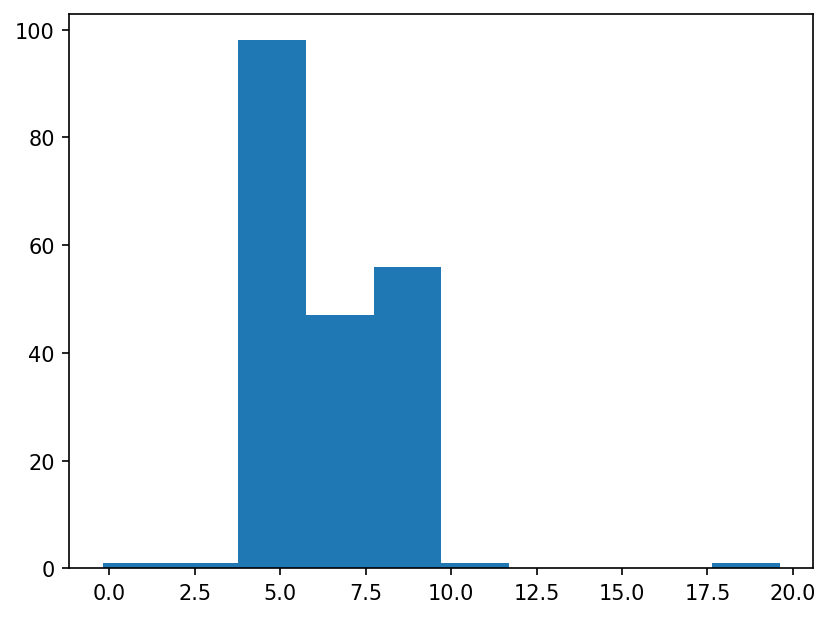

In [85]:
plt.hist(test_predictions_0['y_pred'])

(array([189.,   0.,   2.,   3.,   0.,   0.,   7.,   0.,   1.,   3.]),
 array([6.62024041, 6.74045349, 6.86066656, 6.98087964, 7.10109271,
        7.22130579, 7.34151886, 7.46173194, 7.58194501, 7.70215809,
        7.82237116]),
 <BarContainer object of 10 artists>)

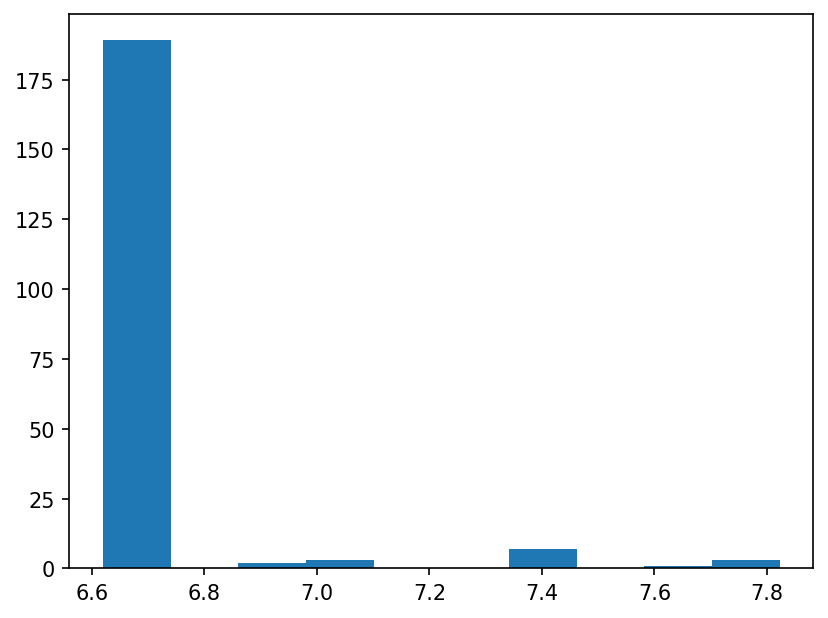

In [84]:
plt.hist(test_predictions_4['y_pred'])

In [83]:
np.exp2(6.632941)

99.24627158529641